# Reflect Tables into SQLAlchemy ORM

In [20]:
#Setup for plotting
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
#Import necessary libraries
import numpy as np
import pandas as pd
import datetime as dt

In [22]:
# Import SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
#Create engine to connect to the SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
#Reflect the existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [25]:
#View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [26]:
#Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [27]:
#Create a session to interact with the database
session = Session(engine)

In [28]:
#Find the most recent date in the data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"Most recent date in the dataset: {last_date}")

Most recent date in the dataset: 2017-08-23


In [29]:
#Calculate the date one year prior to the most recent date
year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(f"Date one year ago: {year_ago.date()}")

Date one year ago: 2016-08-23


In [30]:
#Query for the last 12 months of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago.date(), Measurement.prcp != None).\
    order_by(Measurement.date).all()

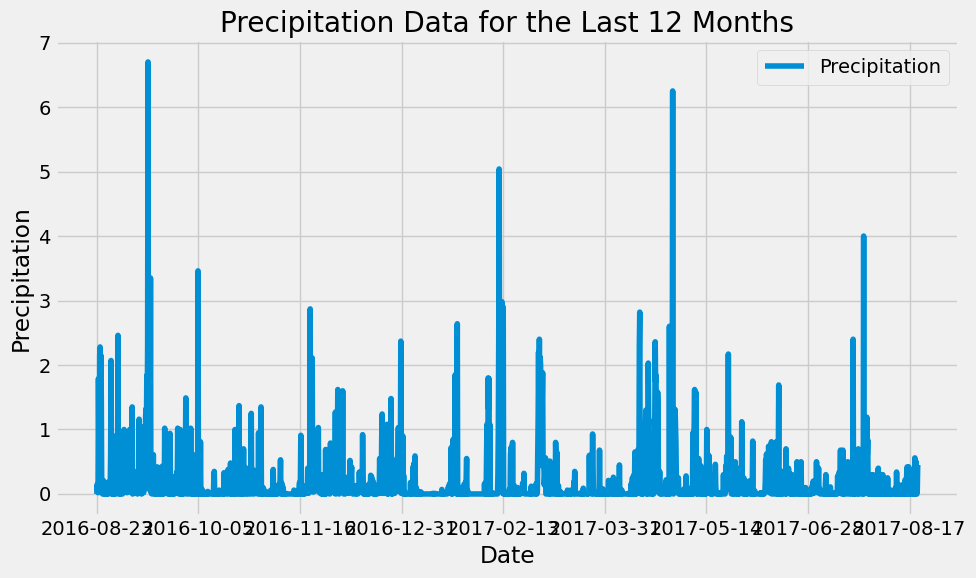

In [31]:
#Convert the data to a DataFrame and plot
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.plot(figsize=(10, 6))
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.tight_layout()
plt.savefig(r'sqlalchemy-challenge.png')
plt.show()

In [32]:
#Calculate summary statistics for precipitation
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
#Query to find the total number of stations
station_count = session.query(Measurement.station).distinct().count()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [34]:
#Query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [35]:
#Using the most active station id, calculate temperature statistics
station_id = 'USC00519281'
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()
print(f"Temperature statistics for station {station_id}:")
print(f"Min Temperature: {temp_stats[0][0]}")
print(f"Max Temperature: {temp_stats[0][1]}")
print(f"Avg Temperature: {temp_stats[0][2]}")

Temperature statistics for station USC00519281:
Min Temperature: 54.0
Max Temperature: 85.0
Avg Temperature: 71.66378066378067


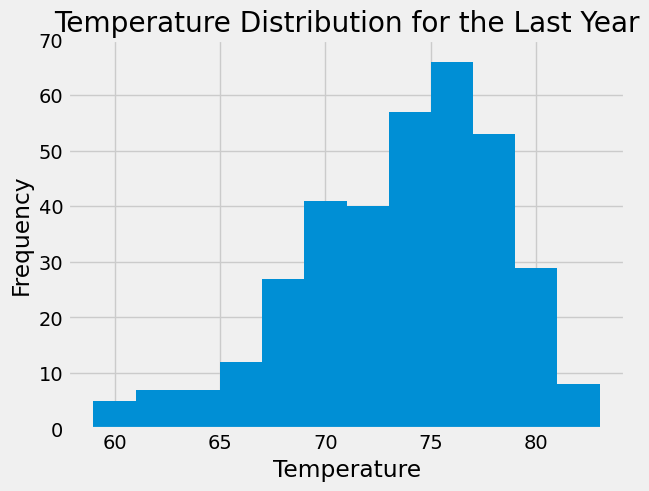

In [36]:
#Query temperature observations for the past year and plot histogram
year_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago.date(), Measurement.station == station_id).\
    order_by(Measurement.tobs).all()

df1 = pd.DataFrame(year_temp, columns=['Tobs'])
df1['Tobs'].plot.hist(bins=12)
plt.title('Temperature Distribution for the Last Year')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.ylim(0, 70)
plt.savefig(r'sqlalchemy-challenge-histogram.png')
plt.show()

# Close Session

In [37]:
# Close Session
session.close()